# Introduction
This project seeks to address the challenge of imitating the style of a particular artist when creating new images or altering existing images. This challenge will be attempted using a generative adversarial network (GAN). GANs consist of a generator model and discriminator model. The generator creates images and the discriminator compares them with real images to train the generator. 

Claude Monet was an important figure in the Impressionist movement. He frequently depicted scenes from Paris and the Normandy coast, particularly landscapes. His style has been described as striving to capture the very act of perceiving nature. Inspired by Japanese woodprints, he emphasized the two-dimensional surfaces of forms and eliminated linear perspective.[3]

The goal of this project is to transform photographs or generate images that imitate this unique style.

# Data
The data for this project was obtained from the Kaggle competition page [2]. The dataset consists of 300 Monet paintings in either JPEG or TFRecord format and 7038 photos in either JPEG or TFRecord format. 

Both the photos and paintings are height 256 pixels, width 256 pixels, and depth 3 for RGB. 

The output required for submission to the Kaggle competition is 7,000-10,000 images in the style of Monet. Converting the 7038 photos in the photo dataset to Monet's style would fit the problem rubric.

# Exploratory Data Analysis
First I will show a few Monet paintings to get a better idea of the style I am trying to reproduce with my model. Next I will explore the dataset with other visualizations to learn more about pixel values and other statistics to guide my GAN architecture.

In [12]:
# Important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# EDA and data preprocessing
from PIL import Image
from random import choice
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'tensorflow.keras'

Painting shape: (256, 256, 3)


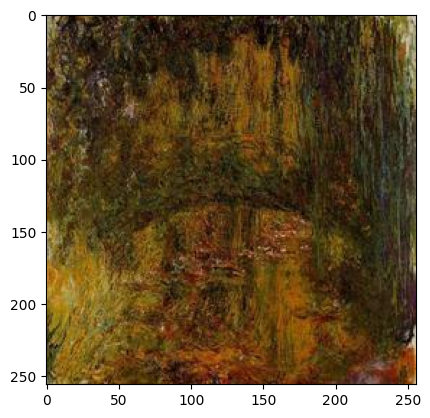

In [3]:
painting_paths = ['\\'.join(['monet_jpg', f]) for f in os.listdir('monet_jpg')]
example_painting_path = choice(painting_paths)
example_painting = Image.open(example_painting_path)
example_painting_array = np.array(example_painting)

print(f'Painting shape: {example_painting_array.shape}')
plt.imshow(example_painting)
plt.show()

In [5]:
# Load the images into ndarray
paintings = np.empty((300, 256, 256, 3))
for i, path in enumerate(painting_paths):
    painting = Image.open(path)
    paintings[i] = np.array(painting)

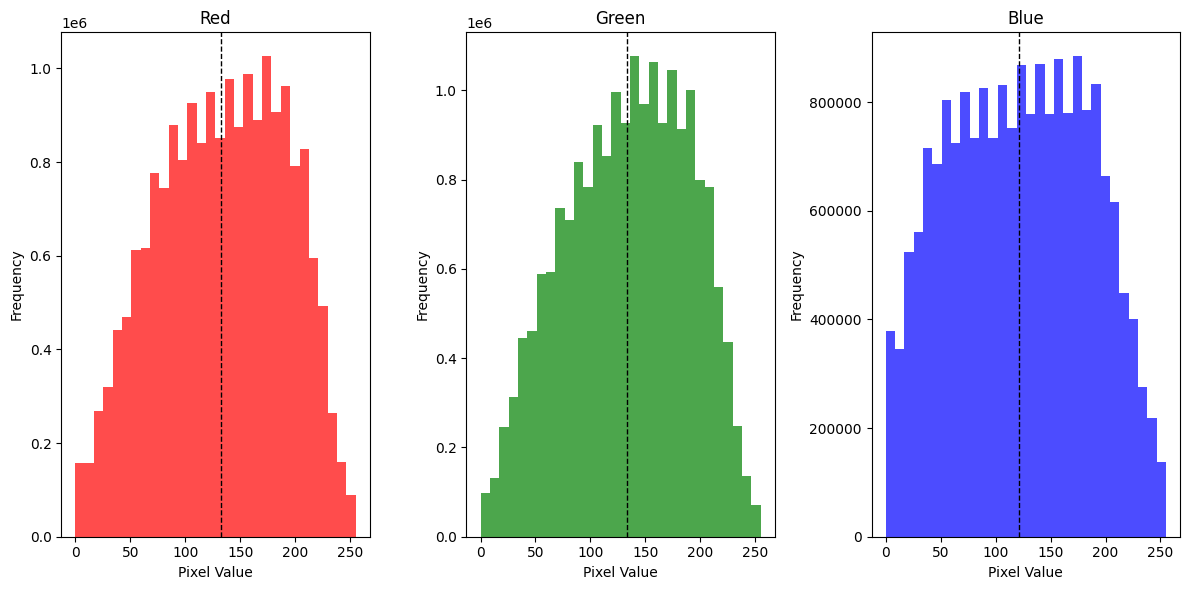

Red mean pixel value: 132.96300455729167
Green mean pixel value: 133.72787953694674
Blue mean pixel value: 121.57267918904626


In [6]:
# Calculate the mean across the first dimension (observations)
mean_values = np.mean(paintings, axis=0)  # Shape will be (96, 96, 3)

# Now, calculate the mean across the spatial dimensions (height and width) for each channel (rgb)
mean_channel_values = np.mean(mean_values, axis=(0, 1))  # Shape will be (3,)

# Create histograms for each channel
colors = ['r', 'g', 'b']  # Assuming channels are in RGB order
channel_labels = ['Red', 'Green', 'Blue']

plt.figure(figsize=(12, 6))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(paintings[..., i].flatten(), bins=30, color=colors[i], alpha=0.7)
    plt.axvline(mean_channel_values[i], color='k', linestyle='dashed', linewidth=1)
    plt.title(channel_labels[i])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

for color, mean in zip(channel_labels, mean_channel_values):
    print(f'{color} mean pixel value: {mean}')

The pixel values appear to be somewhat normally distributed. Green has the highest average pixel value which may be due to Monet's preference for painting landscapes.

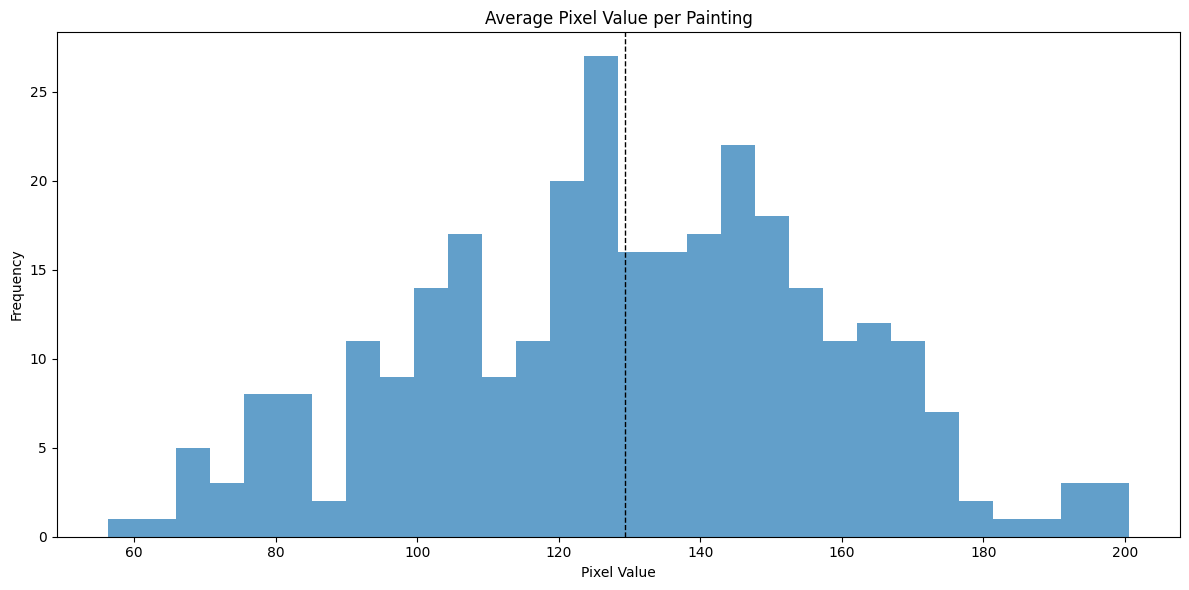

In [7]:
# Calculate the mean pixel value per observation (darkness)
mean_darkness = np.mean(paintings, axis=(1, 2, 3))
overall_average_darkness = np.mean(mean_darkness, axis=0)

# Plot a histogram of mean pixel value per observation
plt.figure(figsize=(12, 6))

plt.hist(mean_darkness, bins=30, alpha=0.7)
plt.axvline(overall_average_darkness, color='k', linestyle='dashed', linewidth=1)
plt.title('Average Pixel Value per Painting')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Photo shape: (256, 256, 3)


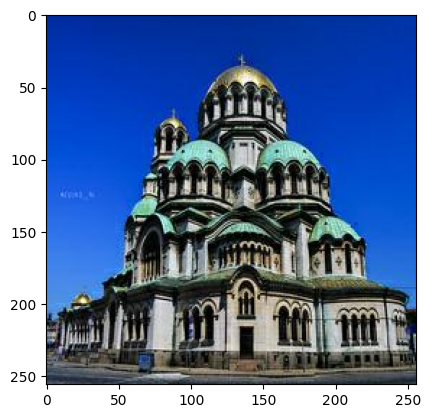

In [4]:
# Load and display and example photo
photo_paths = ['\\'.join(['photo_jpg', f]) for f in os.listdir('photo_jpg')]
example_photo_path = choice(photo_paths)
example_photo = Image.open(example_photo_path)
example_photo_array = np.array(example_photo)

print(f'Photo shape: {example_photo_array.shape}')
plt.imshow(example_photo)
plt.show()

In [10]:
photos = None
photos = np.empty((7038, 256, 256, 3))
for i, path in enumerate(photo_paths):
    photo = Image.open(path)
    photos[i] = np.array(photo)

# Plan of Analysis/Data Cleaning
There are no missing values in the dataset so no imputation is necessary. All of the data is in image form with numerical values for the individual pixels. This means there is no need to encode categorical data. Keras has an ImageDataGenerator class which I will use to preprocess the data. I will create an array of labels in string form identifying the 300 original paintings as real. I will normalize the painting's pixel values to [0,1] range using the rescale parameter. I will take this data cleaning step because different scales can easily be amplified through a neural network and have an outsized effect on the model. 

The main thing of note from EDA is that there are only 300 Monet paintings with which to train the model. This is not enough data to train a model that needs to learn the style well enough to convert 7,000-10,000 photos. I will need to use data augmentation to increase the painting dataset size. I will use on-the-fly augmentation as part of my model pipeline so the model will see a slightly different version of the image each time, improving generalization. Incorporating augmentation into my model architecture also means it will use my GPU, speeding up computation time.

In [ ]:
# Data Augmentation using augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),           # Rotate by up to 10%
    layers.RandomZoom(0.1),               # Zoom by up to 10%
    layers.RandomTranslation(0.1, 0.1),   # Translate by up to 10% horizontally and vertically
    layers.RandomFlip("horizontal"),      # Flip horizontally
    layers.RandomContrast(0.2),           # Adjust contrast by up to 20%
    layers.RandomBrightness(0.2),         # Adjust brightness by up to 20%
    layers.GaussianNoise(0.05),           # Apply Gaussian noise
])

# Plan of Analysis
No max pooling since it destroys spatial information and hurts image quality. I will use convolutional stride for dimensionality reduction instead. 

CycleGAN is specifically designed to transfer styles to images. For this project the model will convert real images to the style of Monet then back to real image. The model will also convert Monet paintings to real images then back to paintings. For both cycles I will apply a discriminator to identify real or generated images. The loss functions for the two reconstruction cycles and discriminators will be combined to guide the training the generators and discriminators. 

Optimizer


# Model Building and Training

# Results and Analysis

# Conclusion and Discussion

## Citations
[1] https://blog.keras.io/building-autoencoders-in-keras.html

[2] https://www.kaggle.com/competitions/gan-getting-started

[3] https://www.metmuseum.org/toah/hd/cmon/hd_cmon.htm

[4] https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7

[5] https://www.tensorflow.org/tutorials/generative/cyclegan